<span style="color:blue">
The main changes are as follows:
    
1. A smaller learning rate 
   
2. Mask correction base on geometry

3. Check value loss inside obstacle

4. The training loop is redefined in functions

   
This notebook follows a custom training loop [(1) ](https://physicsbaseddeeplearning.org/bayesian-code.html), [(2)](https://github.com/thunil/Deep-Flow-Prediction/tree/master) that incorporates a loss function MSE+ and MAE+, as outlined in proposal 
[(3)](https://etna.math.kent.edu/vol.56.2022/pp235-255.dir/pp235-255.pdf).   In the case of MSE+ and MAE+, a constant $C$ is added to multiply the mean relative error component.  
</span>


## <span style="color:blue">1.Imports</span>

In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time
from tqdm                               import tqdm

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt
import pandas as pd


2024-11-24 21:08:16.268917: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 21:08:16.276685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 21:08:16.285942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 21:08:16.288452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 21:08:16.295838: I tensorflow/core/platform/cpu_feature_guar


## <span style="color:blue">2.Load directory</span>

In [2]:
# Files path
directory= os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")

# Add directory to sys.path
sys.path.append(directory)

# import script
import param  

# Set the number of cores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)




## <span style="color:blue">3.Define parameters for data</span>

In [3]:
#Load the main directory
paths=param.list_paths 
for i,j in enumerate(paths):
    print(f'NUM_CLASESS {i} => {j}')

# Defining amount of train,valid,test images
n_train=0.8;    n_valid=0.1;    n_test=0.1

# Defining a sample i.e.
n_sample=500 # 500                   

#Pack them into batches (we’ll use batches of 10 images e.g.)
batch_size= 10                  #10

# For resizing dimentions
h=128
w=256

NUM_CLASESS 0 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry
NUM_CLASESS 1 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude
NUM_CLASESS 2 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Pression
NUM_CLASESS 3 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U001
NUM_CLASESS 4 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U002


## <span style="color:blue">4. Setup</span>
### <span style="color:red">4.1 Hiperparameters</span>

In [4]:
BATCH_SIZE=50               # 50
LR=0.001                    # before       LR = 0.01  
EPOCHS =150                # 150                     
DECAY_RATE=0.015
NUM_CLASESS=1 # Only magnitude e.g.
#num_train_data=geo_array_train.shape[0]     
#  Constants
C=1e-2  # 1e-2
Eps=1e-4
   

## <span style="color:blue">5. Preprocessing </span>

In [5]:
# method for reading image    
def get_img(img_name):
    return ski.io.imread(img_name)
 
# method for turning to a grey or binary image 
def processing(image,option=True):
        x = get_img(image)  
        x = rgb2gray(x)       # It returns a grayscale image with floating point values in the range from 0 to 1
        x =cv.resize(x,(w,h)) # Reshape image 
    
        # Binary option otherwise gray
        if (option):
            x=ski.util.img_as_ubyte(x)  # Convert it back to the original data type and the data range back 0 to 255. 
                                        # It is often better to use image values represented by floating point values 
            best_value_threshold=np.round(filters.threshold_otsu(x)) #  Otsu’s method calculates an “optimal” threshold
            _,x= cv.threshold(x, best_value_threshold, 255, cv.THRESH_BINARY_INV)

        x=x[:, :, np.newaxis]
        return x
    
# method for splitting data
def split_data(path,n_sample,n_train,n_valid,n_test):
        
        files=sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".png")])
        n_files=len(files)
        
        if(n_files>n_sample):
                print()
                print(' ######  \t Loaded ',n_sample,' of ',n_files,'from ',path,'\t #####\n')
                if (n_train + n_valid + n_test == 1.0):
        
                    n_train= math.floor(n_sample*n_train)
                    n_valid = math.floor(n_sample*n_valid) + n_train
                    n_test = math.floor(n_sample*n_test) + n_valid
              
                    (files_train,files_valid,files_tests) = (files[0:n_train], files[n_train:n_valid],files[n_valid:n_test])
                    
                return files_train,files_valid,files_tests

def arrays_img_processed(data,type=True): # True for Geometry 
    # begin in data[1:] 
    if type:
        list_arrays=[processing(image,option=True).astype(np.float32) for image in data[1:] ]
    else:
        list_arrays=[processing(image,option=False).astype(np.float32) for image in data[1:] ]
   
    return np.array(list_arrays) 


In [6]:
# Geometry
geo_train,geo_valid,geo_tests=split_data(paths[0],n_sample,n_train,n_valid,n_test)
geo_array_train=arrays_img_processed(geo_train)
geo_array_valid=arrays_img_processed(geo_valid)
geo_array_tests=arrays_img_processed(geo_tests)

# Magnitude
specific_tarjet=paths[1]

mag_train,mag_valid,mag_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
mag_array_train=arrays_img_processed(mag_train,False)
mag_array_valid=arrays_img_processed(mag_valid,False)
mag_array_tests=arrays_img_processed(mag_tests,False)

print(f'Training data for geometry: {geo_array_train.shape}')
print(f'Training data for magnitude: {mag_array_train.shape}')
print()
print(f'Valid data for geometry: {geo_array_valid.shape}')
print(f'Valid data for magnitude: {mag_array_valid.shape}')
print()
print(f'Test data for geometry: {geo_array_tests.shape}')
print(f'Test data for magnitude: {mag_array_tests.shape}')



 ######  	 Loaded  500  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry 	 #####


 ######  	 Loaded  500  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude 	 #####

Training data for geometry: (399, 128, 256, 1)
Training data for magnitude: (399, 128, 256, 1)

Valid data for geometry: (49, 128, 256, 1)
Valid data for magnitude: (49, 128, 256, 1)

Test data for geometry: (49, 128, 256, 1)
Test data for magnitude: (49, 128, 256, 1)


### <span style="color:red">5.1 TensorFlow Dataset objects</span>
A Dataset object is an iterator. It will typically return batches of input data and tarjet

In [7]:
# slices of an array in the form of objects by using tf.data.Dataset.from_tensor_slices() method
train_data=tf.data.Dataset.from_tensor_slices((geo_array_train, mag_array_train))
valid_data=tf.data.Dataset.from_tensor_slices((geo_array_valid, mag_array_valid))

#representing the number of consecutive elements of this dataset to combine in a single batch
#the last batch is dropped in the case it has fewer than batch_size elements

trainLoader = train_data.batch(batch_size,drop_remainder=True)
valiLoader = valid_data.batch(batch_size,drop_remainder=True)

print("Training & validation batches number: {} , {}\n".format(len(trainLoader),len(valiLoader) ))
i=0;
for geo_batch, mag_batch in trainLoader:
    print("geo batch shape:", geo_batch.shape)
    print("mag batch shape:", mag_batch.shape)
    i=i+1
    print(f'batch number {i}')
    print('------------------')
    break



Training & validation batches number: 39 , 4

geo batch shape: (10, 128, 256, 1)
mag batch shape: (10, 128, 256, 1)
batch number 1
------------------


I0000 00:00:1732500499.062493   54523 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-24 21:08:19.082938: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### <span style="color:red">5.2 Create a mask</span>

In [8]:
#  Tool to create a mask
def create_mask(geo_input,img_1,img_2):
    #creates a copy of the tensor, keeping the same content and shape as the original tensor.
    copy = tf.identity(geo_input)
    
    #  Convert to float32 and normalize to [0, 1]
    mask = tf.cast(copy, tf.float32) / 255.0
    
    img_1_masked=tf.multiply(img_1, mask)
    img_2_masked=tf.multiply(img_2, mask)
    
    # Ip is the set of all pixels that are not covered by the  obstacle
    # Amount of pixels that are ones regarding to the mask
    Ip_value_outside_obstacle = tf.reduce_sum(tf.cast(tf.equal(mask, 1), tf.float32)) 
    
    #Ip_value_inside_obstacle  = tf.size(mask) - Ip_value_outside_obstacle 

    return img_1_masked,img_2_masked,Ip_value_outside_obstacle   

## <span style="color:blue">6. Plot </span>
#### <span style="color:blue">Look at Data </span>


In [9]:
def plot(a1,a2,a3=None,title=None,opt=None):
    
    if opt==None:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Input',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('Geometry',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Target output',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
    elif opt=='plot':
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Real',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('u',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Prediction',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
    else:
        '''
        geo: a3
        u_true: a1
        u_pred: a2
        '''
        a1_mask,a2_mask,count=create_mask(a1,a2,a3)
        
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
        
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax3.set_xticks([]); ax3.set_yticks([]);

        ax1.imshow(a2,origin='upper',cmap='gray')
        ax1.set_title('u_real',fontsize=14)
        #ax2.set_xlabel('u')
        ax1.set_ylabel('u',fontsize=16)
        
        ax2.imshow(a1_mask,origin='upper',cmap='gray')
        ax2.set_title('u_real_masked',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax2.set_ylabel('u',fontsize=14)
        
        ax3.imshow(a3,origin='upper',cmap='gray')
        ax3.set_title('u_pred',fontsize=14)
        #ax2.set_xlabel('u')
        ax3.set_ylabel('u',fontsize=16)
        
        if title is not None: fig.suptitle(title)
        
'''
 NUM=random.sample(range(1, mag_array_train.shape[0]), 1)
plot( mag_array_train[NUM[0]],mag_array_train[NUM[0]], geo_array_train[NUM[0]],title=f"Prediction N°{NUM[0]}",opt='mask')
 '''       
            

'\n NUM=random.sample(range(1, mag_array_train.shape[0]), 1)\nplot( mag_array_train[NUM[0]],mag_array_train[NUM[0]], geo_array_train[NUM[0]],title=f"Prediction N°{NUM[0]}",opt=\'mask\')\n '

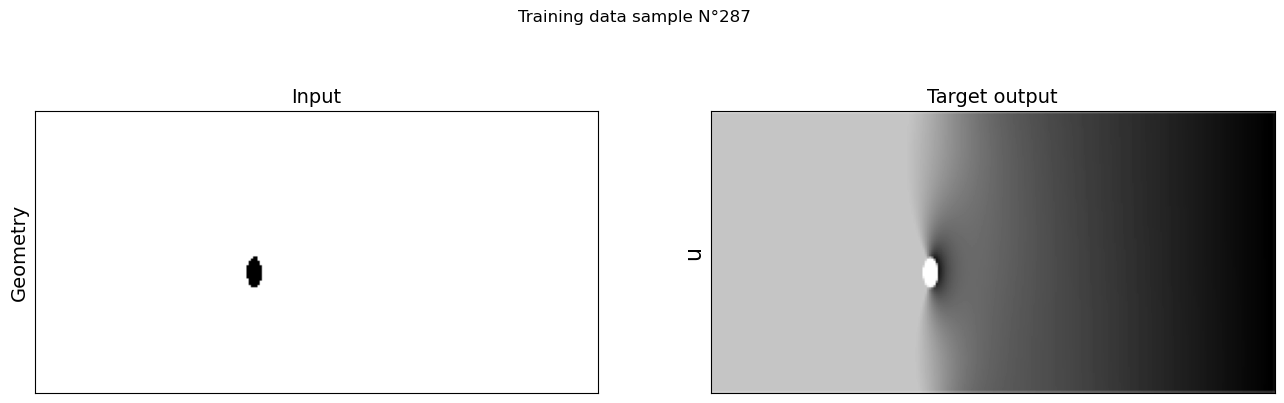

In [10]:
NUM=random.sample(range(1, geo_array_train.shape[0]), 1)
plot( geo_array_train[NUM[0]],mag_array_train[NUM[0]], title=f"Training data sample N°{NUM[0]}") 

## <span style="color:blue">7. Architecture </span>

In [11]:
class U_net(tf.keras.Model):
    
        def __init__(self, num_classes):
            super(U_net,self).__init__()
            
            self.block_1=self.encoder(64)
            self.pool_1=MaxPooling2D((2, 2))

            self.block_2=self.encoder(128)
            self.pool_2=MaxPooling2D((2, 2))

            self.block_3=self.encoder(256)
            self.pool_3=MaxPooling2D((2, 2))

            self.block_4=self.encoder(512)
            self.pool_4=MaxPooling2D((2, 2))

            self.bottleneck_1=Conv2D(1024, (3,3), activation='relu', padding='same')
            self.bottleneck_2=Conv2D(1024, (3,3), activation='relu', padding='same')

            self.up_block_1=self.decoder(512)
            self.up_block_2=self.decoder(256)
            self.up_block_3=self.decoder(128)
            self.up_block_4=self.decoder(64)

            self.output_model=Conv2D(num_classes, (1, 1), activation="relu", padding="same")


        def encoder(self,num_filters):
            
            block = tf.keras.Sequential(name='Encoder_part')
            block.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
            block.add(BatchNormalization())
            block.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
            block.add(BatchNormalization())

            return block

        def decoder(self,num_filters):
            
             block = tf.keras.Sequential(name='decoder_part')
             block.add(Conv2DTranspose(num_filters,(2,2),strides=(2, 2),padding="same"))
             block.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
             block.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same'))

             return block
            
        # Forward pass 
        def call(self,inputs,training=False):
            #inputs=Input((h, w,1))
            
            #Encoder
            x1=self.block_1(inputs)
            p1=self.pool_1(x1)

            x2=self.block_2(p1)
            p2=self.pool_2(x2)
            
            x3=self.block_3(p2)
            p3=self.pool_3(x3)
            
            x4=self.block_4(p3)
            p4=self.pool_4(x4)

            b1= self.bottleneck_1(p4)
            b2= self.bottleneck_2(b1)

            # Decoder
            u1 = self.up_block_1(b2)
            u2 = concatenate([u1, x4])

            u3 = self.up_block_2(u2)
            u4 = concatenate([u3, x3])

            u5 = self.up_block_3(u4)
            u6 = concatenate([u5, x2])

            u7 = self.up_block_4(u6)
            u8 = concatenate([u7, x1])

            outputs = self.output_model(u8)
            return outputs
        
  

### <span style="color:red">7.1 Learning rate</span>

Exponential Decay: 

$$ lr=lr_{ initial } \times e ^{-\text{decate rate} \times \text{epoch}} $$

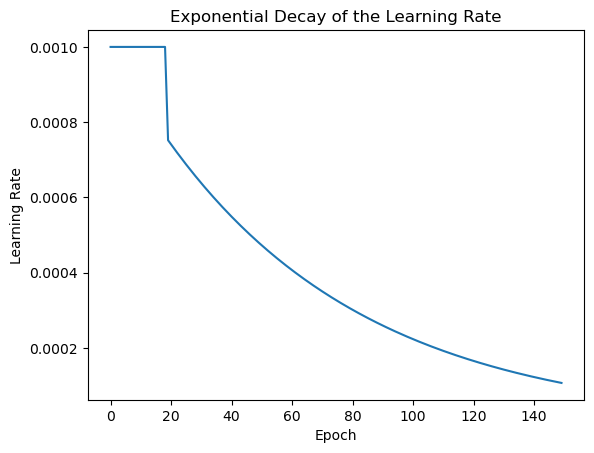

In [12]:
def exponential_decay(epoch,epochs,lr_ini=LR,decay_rate=DECAY_RATE):
    if epoch < epochs/(2**3): # before 2³ = 8  poner 2 ^5 
        return lr_ini
    else:
        return  lr_ini * np.exp(-decay_rate*epoch)
    
epochs = np.arange(EPOCHS)
learning_rates = [exponential_decay(epoch,EPOCHS) for epoch in epochs]

plt.plot(epochs, learning_rates, label="Learning Rate")
plt.title("Exponential Decay of the Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(False)
plt.show()    

### <span style="color:red">7.2 Loss function</span>
Definition of custom loss function MSEplus

$$  MSEplus = MSE + C(MRE)$$

$$ MSEplus =  \frac{1}{|I_P|} \sum_{p \in I_P} \Big( \left\|u_p - \hat{u}_p \right\|_2^2 + C \frac{\left\|u_p - \hat{u}_p \right\|_2}{ \left\|u_p  \right\|_2 + 10^{-4}}\Big) $$

where
$$ MRE = \frac{1}{|I_P|} \sum_{p \in I_P} \Big (\frac{\left\|u_p - \hat{u}_p \right\|_2}{ \left\|u_p \right\|_2 + 10^{-4} }\Big) $$
#### $u_p$ is the velocity prediction vector at pixel $p$.

#### $\hat{u}_p$ is the reference velocity at $p$, i.e.,the evaluation of the CFD solution.

#### $I_P$ is the set of all pixels $p$ that are not covered by the respective obstacle.

#### <span style="color:red">0.0 -> Black </span>
#### <span style="color:red">1.0 (255) ->White</span>
## ![Ilustration](mask.png)

In [13]:

def MSEplus(geo):
    def loss_fn(u_true,u_pred):
            Eps=1e-4
            # call method create_mask
            u_true_masked, u_pred_masked, Ip_value=create_mask(geo,u_true,u_pred)
            e=u_true-u_pred
            error = u_true_masked - u_pred_masked
            mse = tf.reduce_sum(tf.square(error))
        
            norm_error = tf.sqrt(tf.reduce_sum(tf.square(error)))
            
            norm_u_pred=tf.sqrt(tf.reduce_sum(tf.square(u_pred_masked)))
            mre=norm_error/(norm_u_pred + Eps)
            mre=C*mre
            mre=tf.reduce_sum(mre)
            # Calculates the MREplus over all pixels outside the obstacle
            Mseplus= (mse + mre)/Ip_value
    
            ###  check the loss inside obstacle
            index = tf.where(error == 0.0)
            count = tf.reduce_sum(tf.cast(error == 0, tf.float32))
        
            try:
                values = tf.gather_nd(error, index)
                mse_obs = tf.reduce_sum(tf.square(values))
                norm_obstacle=tf.sqrt(tf.reduce_sum(tf.square(values)))
                mre_obs=C*tf.reduce_sum(norm_obstacle/(norm_u_pred + Eps))
                error_obs= (mse_obs+mre_obs)/count
        
            except tf.errors.InvalidArgumentError as e:
             print(f"Error: {e}")  
            return Mseplus,error_obs
    return loss_fn
        

    
'''
loss_mseplus=mseplus(geo)
_,_=loss_mseplus(x,y)
'''

'\nloss_mseplus=mseplus(geo)\n_,_=loss_mseplus(x,y)\n'

### <span style="color:red">7.3 Metric</span>
#### Definition of custom metric function MAE+
<strong>Implementing a custom metric by subclassing </strong> 
#### [See tf.keras.Metric](https://www.tensorflow.org/api_docs/python/tf/keras/Metric) 

<strong>__ init __():</strong> All state variables should be created in this method by calling self.add_variable() like:  
self.var = self.add_variable(...)

<strong>update_state():</strong> Has all updates to the state variables like: self.var.assign(...).

<strong>result():</strong> Computes and returns a scalar value or a dict of scalar values for the metric from the state variables.

$$MAE+ = \frac{1}{|I_P|} \sum_{p \in I_P} (\left\|u_p - \hat{u}_p \right\|_1 + C  \frac{ \left\| u_p - \hat{u}_p  \right\|_2 }{\left\| u_p  \right\|_2 + 10^{-4}})$$

In [14]:

class MAE(tf.keras.metrics.Metric):
    
    def __init__(self, name="MaePlus", **kwargs):
        super().__init__(name=name, **kwargs)
        
        self.mae_sum = self.add_weight(name="mae_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros",dtype="int32")
        
    def update_state(self, geo, u_true, u_pred, sample_weight=None):
        
        # Regularizar  
          Eps=1e-4
          u_true_masked,u_pred_masked, Ip_value=create_mask(geo, u_true,u_pred)
          error= u_true_masked  - u_pred_masked
          mae= tf.reduce_sum(tf.abs(error))  
        
          norm_error = tf.sqrt(tf.reduce_sum(tf.square(error)))
          norm_u_pred=tf.sqrt(tf.reduce_sum(tf.square(u_pred_masked))) 
          mre=C*norm_error/(norm_u_pred + Eps)
        
          mre=tf.reduce_sum(mre)
          maeplus=(mae + mre)/Ip_value
        
          self.mae_sum.assign_add(maeplus)
          self.total_samples.assign_add(tf.cast(tf.size(u_true), tf.float32))

    def result(self):
        return self.mae_sum / tf.cast(self.total_samples, tf.float32)

    def reset_states(self):
        self.mae_sum.assign(0.0)
        self.total_samples.assign(0)


### <span style="color:red">7.4 Building a Training Loop</span>
[Writing a training loop from tensorflow](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

[Effective Tensorflow 2](https://www.tensorflow.org/guide/effective_tf2)

[Custom Training Loop github](https://github.com/naveed88375/AI-ML/tree/master/Tensorflow%20Custom%20Training%20Loop)

In [15]:
'''
Gradient descent (with momentum) optimizer

momentum:
float hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations.
0 is vanilla gradient descent. Defaults to 0.0. 

Update rule for parameter w with gradient g when momentum is 0: w = w - learning_rate * g

Update rule when momentum is larger than 0: velocity = momentum * velocity - learning_rate * g,  w = w + velocity
'''

# Create an instance of the model
modelU = U_net(num_classes=NUM_CLASESS)

# Instantiate an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)

# Prepare the metrics.
train_metric = MAE()
val_metric = MAE()

  

#### [Speeding-up the training step with tf.function](https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/)
Layers and models recursively track any losses created during the forward pass by layers that call self.add_loss(value). The resulting list of scalar loss values are available via the property model.losses at the end of the forward pass.

In [16]:
# # Writing a step-by-step training loop: the training step function
# f(x)=y 
@tf.function
#-----------------------------------------------------------------------------------------------
def train_step(x,y):
     with tf.GradientTape(persistent=True) as tape:
        logits=modelU(x,training=True) 
         
        loss_mseplus=MSEplus(x) # call loss function
        mseplus_out,error_in=loss_mseplus(y,logits)
        loss_track=sum(modelU.losses)
        mseplus_total= mseplus_out+loss_track
        
        
     gradients_mseplus = tape.gradient(mseplus_total, modelU.trainable_variables)
     optimizer.apply_gradients(zip(gradients_mseplus, modelU.trainable_variables))
    
     gradients_error_in = tape.gradient(error_in, modelU.trainable_variables)
     optimizer.apply_gradients(zip(gradients_error_in, modelU.trainable_variables))
     
     logs_train={}
     train_metric.update_state(x,y,logits)  # Update the metric

     logs_train['MSE+']                 =mseplus_out
     logs_train['Total_MSE+']           =mseplus_total
     logs_train['Error_inside_obstacle']=error_in
     logs_train['Loss_track']           =loss_track
     logs_train[train_metric.name]      =train_metric.result()
    

     return logs_train



In [17]:
@tf.function
#-----------------------------------------------------------------------------------------------
def test_step(x,y):
    logits = modelU(x,training=False)
    loss_mseplus=MSEplus(x) # call loss function
    mseplus_out,error_in=loss_mseplus(y,logits)
    #mseplus_out,error_in=MSEplus(x,y,logits)
    logs={}
    val_metric.update_state(x,y,logits)
    logs['val_mseplus']=mseplus_out
    logs["val_" + val_metric.name]= val_metric.result()
    logs["val_error_inside_obs"]=error_in
    return logs


In [18]:
# ===============================================================================
# Writing a step-by-step training loop: the loop itself  
total_mseplus=[]
total_error=[]
total_metric=[]
losses_track=[]
mseplus=[]

val_total_mseplus=[]
val_total_error=[]
val_total_metric=[]

for epoch in range(EPOCHS):
    start_time = time.time()
    
    Tmseplus=0
    error_obs=0
    metric=0
    l_t=0
    Mseplus=0

    # Call to exponential_decay function
    currLr = exponential_decay(epoch,EPOCHS)
    if currLr < LR:
       optimizer.learning_rate=currLr
    #--------------------------------------------------------------------------------
    for step, (x_train,y_train) in enumerate(trainLoader):
            logs_train=train_step(x_train,y_train)
        
            Mseplus   += logs_train['MSE+']
            Tmseplus  += logs_train['Total_MSE+']
            error_obs += logs_train['Error_inside_obstacle']
            l_t       += logs_train['Loss_track']
            metric    += logs_train[train_metric.name]

 
    mseplus      +=[Mseplus/len(trainLoader)]    
    total_mseplus+=[Tmseplus/len(trainLoader)]
    total_error  +=[metric/len(trainLoader)]
    total_metric += [error_obs/len(trainLoader)]
    losses_track += [l_t/len(trainLoader)]
    
    train_metric.reset_state() ##corregir

# =======================================================================================
#  Writing a step-by-step evaluation loop   
    val_mseplus=0
    val_error_obs=0
    metric_val=0

    for step, (x_val,y_val) in enumerate(valiLoader):
        logs_val = test_step(x_val, y_val)
        
      
        val_mseplus += logs_val['val_mseplus']
        val_error_obs += logs_val["val_" + val_metric.name]
        metric_val += logs_val["val_error_inside_obs"]
  
    val_total_mseplus+=[val_mseplus/len(valiLoader)]
    val_total_error+=[ metric_val/len(valiLoader)]
    val_total_metric += [val_error_obs/len(valiLoader)]
    val_metric.reset_states()  
    
    if epoch<1 or epoch%5==0:
        print(f'Epoch {epoch}/{EPOCHS}')  
        for key, value in logs_train.items():
             print(f"\t...{key}: {value:.10f}")
        print('\n')    
        for key, value in logs_val.items():
             print(f"\t...{key}: {value:.10f}")
            
print("\n****** Time taken: %.2fs" % (time.time() - start_time))   



2024-11-24 21:10:09.530347: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-24 21:10:11.945850: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016355


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000


2024-11-24 21:12:04.689373: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-24 21:15:54.391422: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000


2024-11-24 21:23:40.718716: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000


2024-11-24 21:39:17.658009: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 20/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 25/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 30/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.000001

2024-11-24 22:10:29.773738: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 40/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 45/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 50/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.000001

2024-11-24 23:13:57.154041: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 65/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 70/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 75/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 80/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.000001

2024-11-25 01:24:39.232118: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 130/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 135/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 140/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.0000016349
	...val_error_inside_obs: 0.0000000000
Epoch 145/150
	...MSE+: 0.3719278276
	...Total_MSE+: 0.3719278276
	...Error_inside_obstacle: 0.0000000000
	...Loss_track: 0.0000000000
	...MaePlus: 0.0000016378


	...val_mseplus: 0.3682837188
	...val_MaePlus: 0.00

NameError: name 'modeloU' is not defined

In [20]:
modelU.save_weights('Weight_model_ver3.5_ex_1.weights.h5')
# nuevo_modelo.load_weights('pesos_modelo.h5')

#### Number of trainable parameters

In [21]:
num_params = np.sum([np.prod(v.shape.as_list()) for v in modelU.trainable_variables])
print('The U-Net has {} parameters.'.format(num_params)) 
modelU.summary()

The U-Net has 28589185 parameters.


Model: "u_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_part (Sequential)       │ (10, 128, 256, 64)     │        38,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (10, 64, 128, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_part (Sequential)       │ (10, 64, 128, 128)     │       222,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (10, 32, 64, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_part (Sequential)       │ (10, 32, 64, 256)      │       887,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (10, 16, 32, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_part (Sequential)       │ (10, 16, 32, 512)      │     3,544,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (10, 8, 16, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (10, 8, 16, 1024)      │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (10, 8, 16, 1024)      │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_part (Sequential)       │ (10, 16, 32, 512)      │     6,817,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_part (Sequential)       │ (10, 32, 64, 256)      │     2,228,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_part (Sequential)       │ (10, 64, 128, 128)     │       557,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_part (Sequential)       │ (10, 128, 256, 64)     │       139,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (10, 128, 256, 1)      │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,593,025 (109.07 MB)

 Trainable params: 28,589,185 (109.06 MB)

 Non-trainable params: 3,840 (15.00 KB)

## <span style="color:blue">8. Visualizing results</span>

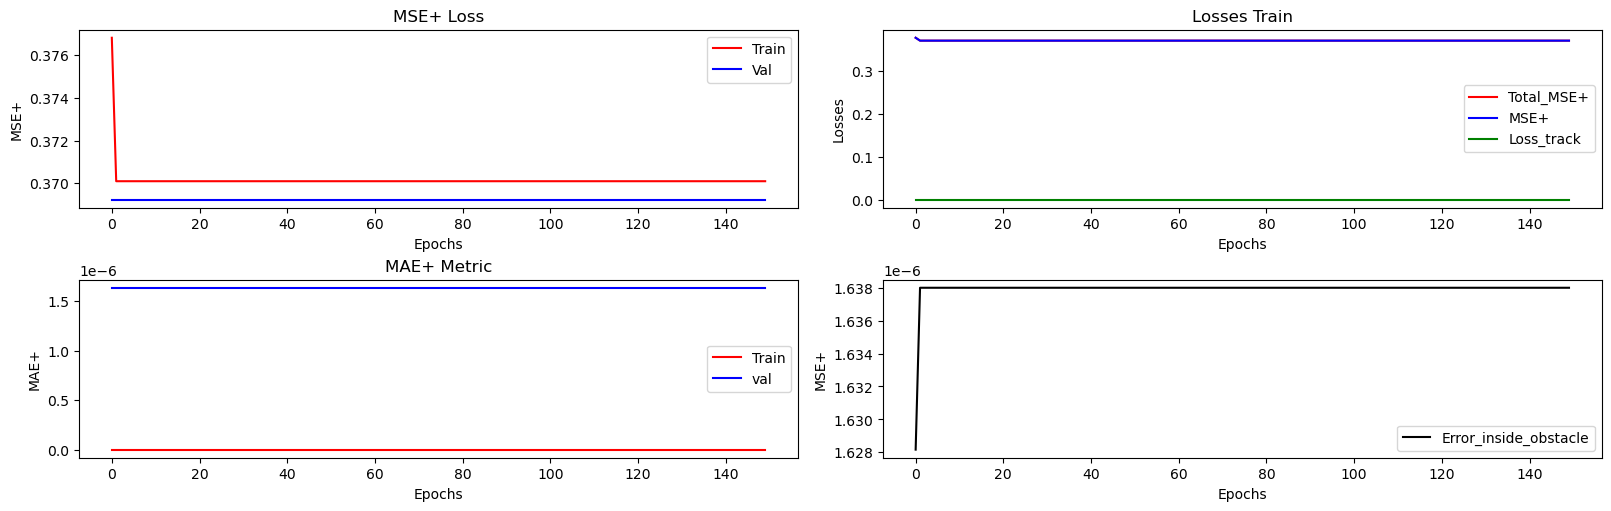

In [26]:
#fig, (ax,ax1,ax2) = plt.subplots(3, 1,layout='constrained')
#fig, (ax1,ax2,ax) =plt.subplots(1, 3, figsize=(16, 5),layout='constrained')
fig, axs =plt.subplots(2, 2, figsize=(16, 5),layout='constrained')
ax1, ax2, ax3, ax4 = axs.ravel()
ax1.plot(mseplus,color='red',label='Train')
ax1.plot(val_total_mseplus,color='blue',label='Val')
ax1.set_title('MSE+ Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE+')
ax1.legend()
#---------------------------------------------------------
ax2.plot(total_mseplus,color='red',label='Total_MSE+')
ax2.plot(mseplus,color='blue',label='MSE+')
ax2.plot(losses_track ,color='green',label='Loss_track')
ax2.set_title('Losses Train')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Losses')
ax2.legend()
#--------------------------------------------------------------------
ax3.plot(total_metric,color='red',label='Train')
ax3.plot(val_total_metric,color='blue',label='val')
ax3.set_title('MAE+ Metric')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MAE+')
ax3.legend()

ax4.plot(total_error,color='black',label='Error_inside_obstacle')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE+')
ax4.legend()
plt.savefig("Results.png", dpi=300, bbox_inches='tight')

## <span style="color:blue">9. Statistics</span>

In [29]:

results = {
    'Epoch':list(range(EPOCHS)),
    'MSE+ Train':[tensor.numpy() for tensor in mseplus],
    'Loss Track Train':[tensor.numpy() for tensor in losses_track],
    'Total MSE+ Train':[ tensor.numpy() for tensor in total_mseplus],
    'MSE+ Val':[tensor.numpy() for tensor in val_total_mseplus] ,
    'MAE+ Train':[tensor.numpy() for tensor in total_metric] ,
    'MAE+ Val': [tensor.numpy() for tensor in val_total_metric] ,
    'MSE+ Obstacle': [tensor.numpy() for tensor in total_error] 
}

df = pd.DataFrame(results)
print('\n Dataframe')
print(df.head(10))
print('\n Statistics')
stats = df[['MSE+ Train', 'Loss Track Train','Total MSE+ Train','MSE+ Val','MAE+ Train','MAE+ Val','MSE+ Obstacle']].describe()
print(stats)




 Dataframe
   Epoch  MSE+ Train  Loss Track Train  Total MSE+ Train  MSE+ Val  \
0      0    0.376823               0.0          0.376823  0.369234   
1      1    0.370097               0.0          0.370097  0.369234   
2      2    0.370097               0.0          0.370097  0.369234   
3      3    0.370097               0.0          0.370097  0.369234   
4      4    0.370097               0.0          0.370097  0.369234   
5      5    0.370097               0.0          0.370097  0.369234   
6      6    0.370097               0.0          0.370097  0.369234   
7      7    0.370097               0.0          0.370097  0.369234   
8      8    0.370097               0.0          0.370097  0.369234   
9      9    0.370097               0.0          0.370097  0.369234   

   MAE+ Train  MAE+ Val  MSE+ Obstacle  
0         0.0  0.000002       0.000002  
1         0.0  0.000002       0.000002  
2         0.0  0.000002       0.000002  
3         0.0  0.000002       0.000002  
4         0.

## <span style="color:blue">10. Predictions</span>

In [30]:
u_predictions = modelU.predict(geo_array_tests) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 976ms/step


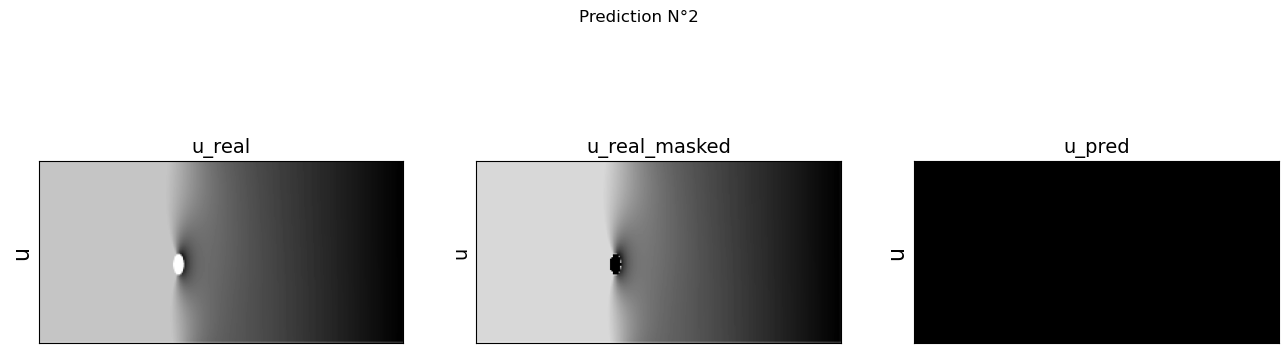

In [33]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot(geo_array_train[NUM[0]],mag_array_train[NUM[0]], u_predictions[NUM[0]],title=f"Prediction N°{NUM[0]}",opt='mask')

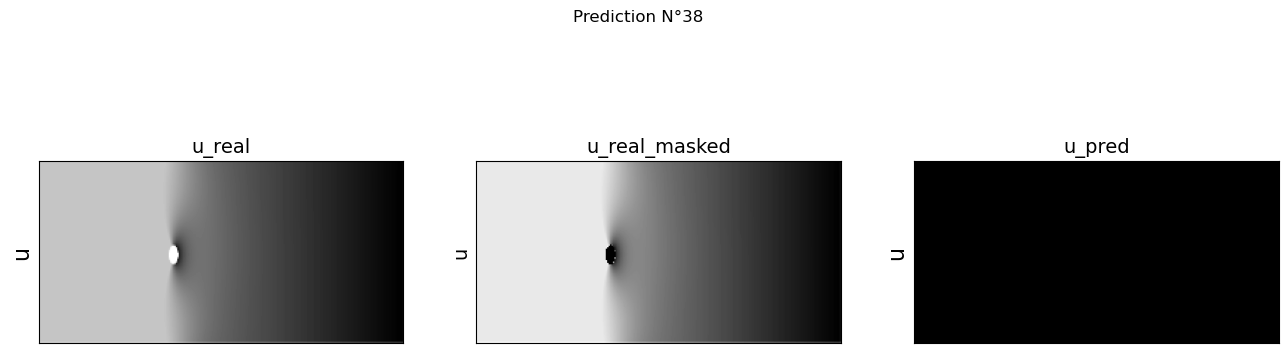

In [35]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot(geo_array_train[NUM[0]],mag_array_train[NUM[0]], u_predictions[NUM[0]],title=f"Prediction N°{NUM[0]}",opt='mask')

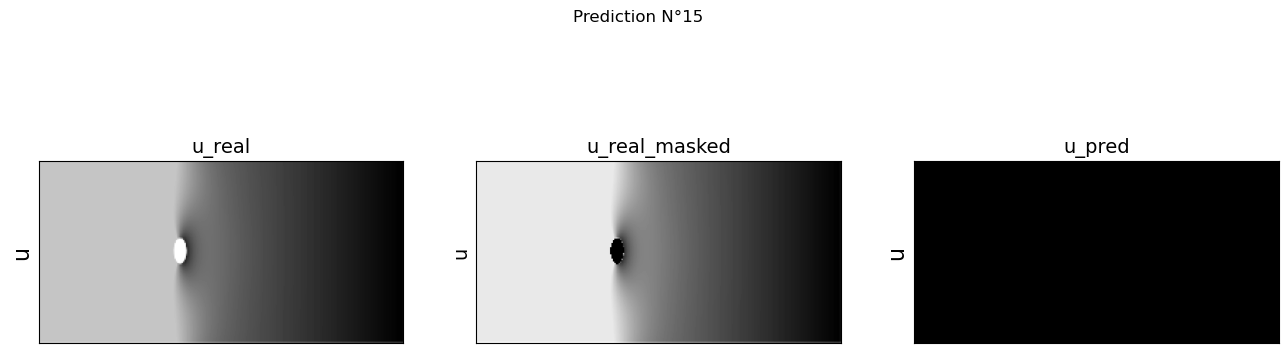

In [36]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot(geo_array_train[NUM[0]],mag_array_train[NUM[0]], u_predictions[NUM[0]],title=f"Prediction N°{NUM[0]}",opt='mask')

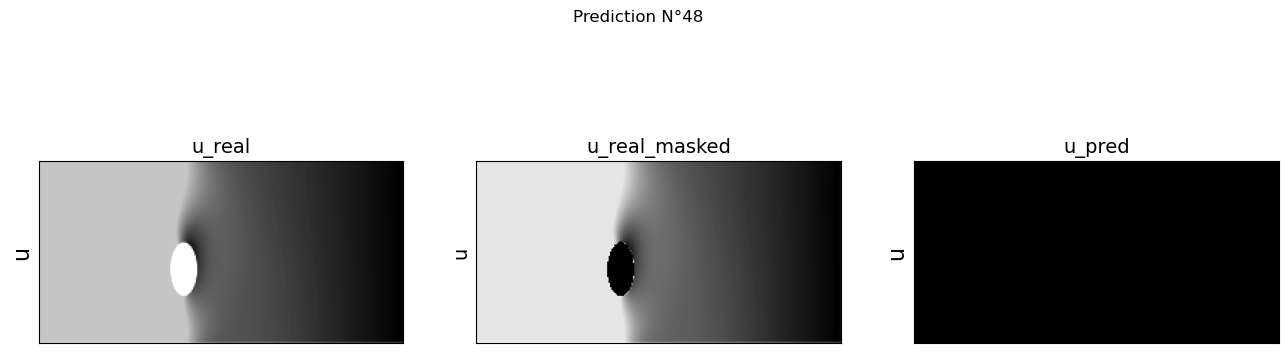

In [37]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot(geo_array_train[NUM[0]],mag_array_train[NUM[0]], u_predictions[NUM[0]],title=f"Prediction N°{NUM[0]}",opt='mask')

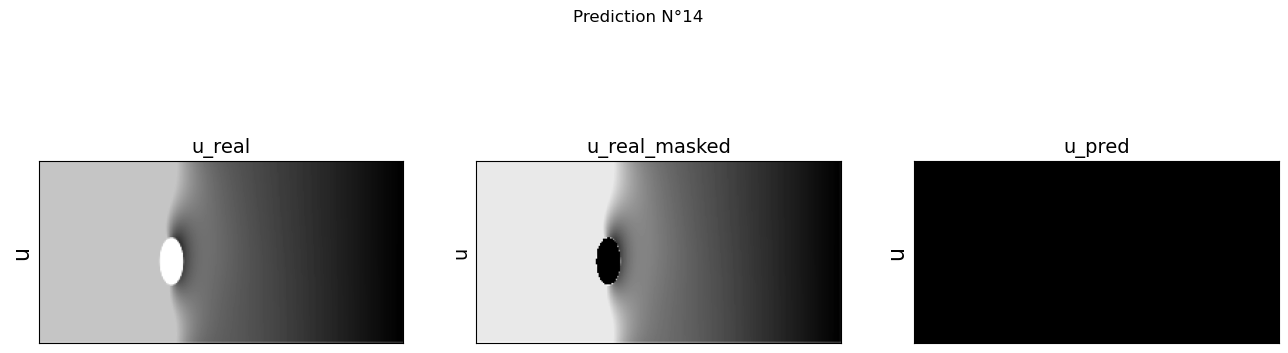

In [38]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot(geo_array_train[NUM[0]],mag_array_train[NUM[0]], u_predictions[NUM[0]],title=f"Prediction N°{NUM[0]}",opt='mask')

[Attention U-Net - Video](https://www.youtube.com/watch?v=dirDQdHDi7I)

[U-Net vs Attention U-Net vs Attention Residual U-Net - Video ](https://www.youtube.com/watch?v=L5iV5BHkMzM)

[Attention U-net. What is attention and why is it needed for U-Net? - Video ](https://www.youtube.com/watch?v=KOF38xAvo8I)

[Attention U-Net: Learning Where to Look for the Pancreas - paper](https://arxiv.org/pdf/1804.03999)

[A U-net segmentation model for predicting free convection over confined isothermal tubes - paper](https://www.sciencedirect.com/science/article/abs/pii/S0735193324000332)



In [ ]:
'''
fig, axs = plt.subplots(2, 1,layout='constrained')
axs[0].plot(mse_total_train,color='red',label='train')
axs[0].plot(mse_total_val,color='blue',label='val')
axs[0].set_title('Total MSE Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE+')
axs[0].legend()

axs[1].plot(mae_total_train,color='red',label='train')
axs[1].plot(mae_total_val,color='blue',label='val')
axs[1].set_title('Total MAE Training and Validation Metric');
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE+')
axs[1].legend()
'''

In [ ]:
'''
def MRE (geo,u_true,u_pred): # Mean Relative Error 
    
     # call method create_mask
    u_true_masked,u_pred_masked, Ip_value=create_mask(geo, u_true, u_pred)
    
    error = u_true_masked - u_pred_masked
    norm_error = tf.sqrt(tf.reduce_sum(tf.square(error)))
    norm_u_true=tf.sqrt(tf.reduce_sum(tf.square(u_true_masked)))
    mre=norm_error/norm_u_true
    
    # Calculates the MRE over all pixels outside the obstacle
    mre=tf.reduce_sum(mre)/Ip_value
    
    return mre
'''

In [ ]:
imagen_mascarada 